# Calibration of Black and Scholes, Merton, Kou, Variance Gamma parameters
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.


In [1]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo

random.seed(100)

Let's start retrieving historical prices for **european call** and **put** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. Only options such that
$$ K = S0 \pm 1200 $$ have been selected.

In [2]:
df_call = pd.read_csv('data/options_spx_call_2016.csv')
df_put = pd.read_csv('data/options_spx_put_2016.csv')
print(f'NUM OF CALL OPTS: {df_call.shape[0]}')
print(df_call.head(5))
print(f'NUM OF PUT OPTS: {df_put.shape[0]}')
print(df_put.tail(5))

NUM OF CALL OPTS: 83
   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE    C_BID    C_ASK  STRIKE
0  2016-01-20          1859.48  2017-01-20  1119.61  1125.01   700.0
1  2016-01-20          1859.48  2017-01-20  1071.51  1076.80   750.0
2  2016-01-20          1859.48  2017-01-20  1023.00  1028.30   800.0
3  2016-01-20          1859.48  2017-01-20   998.40  1003.60   825.0
4  2016-01-20          1859.48  2017-01-20   974.29   979.51   850.0
NUM OF PUT OPTS: 83
    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE    P_BID    P_ASK  STRIKE
78  2016-01-20          1859.48  2017-01-20   958.80   964.10  2800.0
79  2016-01-20          1859.48  2017-01-20  1007.99  1013.29  2850.0
80  2016-01-20          1859.48  2017-01-20  1057.50  1062.90  2900.0
81  2016-01-20          1859.48  2017-01-20  1107.01  1112.50  2950.0
82  2016-01-20          1859.48  2017-01-20  1156.49  1162.01  3000.0


The dataframes **df_calls** and **df_put** contain both 83 options sorted by strike price. For our purpose, using the $25\%$ of these DFs is enough and can lead to very good results. Thus, we sample the rows and then reformulate the dataframes adding **Midpoint** and **Spread** columns.

In [3]:
calls = df_call.sample(frac=0.25, replace=False).sort_index()
puts = df_put.sample(frac=0.25, replace=False).sort_index()

calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']

q = 0           # dividend yield
r = 0.05        # risk-free interest rate
sigma = 0.2     #volatility (variance of diffusion process)
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
call_strikes = calls['STRIKE']    # array of K for call options
put_strikes = puts['STRIKE']      # array of K for put options
exercise = 'european'

call_prices = calls['C_Midpoint']
put_prices = puts['P_Midpoint']

The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. Then it computes the theoretical call prices using closed formulas of each 4 models, with strike prices given by the *call_strikes* array. Additionally, we use the **Midpoint** price as the option market prices.

In [4]:
BS = BS_pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=0.05, q = q, sigma=0.12, lambd=0.5, meanJ=-0.1, stdJ=0.2, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.12, lambd=0.5, p=0.6, eta1=10, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.2, exercise=exercise)

call_th_prices = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
call_th_prices['Strike'] = call_strikes

for i, K in enumerate(call_strikes):
    bs = BS.closed_formula_call(K)
    mert = Merton.closed_formula_call(K)
    kou = Kou.closed_formula_call(K)
    vg = VG.closed_formula_call(K)
    call_th_prices.iloc[i, 1:] = [bs, mert, kou, vg]

print(f'Theoretical call options prices:')
print(call_th_prices.head(5)) #print(call_th_prices.tail(4))

Theoretical call options prices:
    Strike BlackScholes       Merton          Kou VarianceGamma
0    700.0  1193.619409  1193.662047  1193.840257   1193.619403
4    850.0  1050.935822  1051.160724  1051.587513   1050.934993
11  1025.0   884.514589   885.539147   886.321118    884.470397
13  1075.0    837.01712   838.485934    839.32137    836.910302
16  1150.0   765.917343   768.286198   769.077207    765.576912


Same for put prices.

In [5]:
put_th_prices = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
put_th_prices['Strike'] = put_strikes

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    vg = VG.closed_formula_put(K)
    put_th_prices.iloc[i, 1:] = [bs, mert, kou, vg]

print(f'Theoretical put options prices:')
print(put_th_prices.head(5))

Theoretical put options prices:
   Strike BlackScholes    Merton       Kou VarianceGamma
0   700.0     0.000006  0.042644  0.220854           0.0
3   825.0      0.00041  0.175383  0.552468      0.000002
4   850.0     0.000833  0.225735  0.652524      0.000003
7   925.0     0.005556  0.458208  1.045308      0.000036
9   975.0     0.016682  0.708717  1.401433      0.000147


### Variance Gamma Fast Fourier Transform
Let's now compare the Closed Forms with the Fast Fourier Transform method for the Variance Gamma model for both call and put options.  The FFT method is explained by Carr, Madan, Chang 1998: *The Variance Gamma Process and Option Pricing*.

In [6]:
c_vg_fft = VG.FFT_call(call_strikes)

for k, a, b in zip(call_strikes, call_th_prices['VarianceGamma'], c_vg_fft):
    print(f'K={k}, CF:{a}, FFT:{b}')

K=700.0, CF:1193.6194028637115, FFT:1193.621720743016
K=850.0, CF:1050.9349926399627, FFT:1050.9593216136195
K=1025.0, CF:884.4703974552734, FFT:884.6859262227545
K=1075.0, CF:836.9103022995379, FFT:837.2789621400237
K=1150.0, CF:765.576912289833, FFT:766.3511908233695
K=1225.0, CF:694.2745279760636, FFT:695.7852761857221
K=1250.0, CF:670.5250248213247, FFT:672.3817017723422
K=1425.0, CF:505.4636271748957, FFT:511.50185790186333
K=1600.0, CF:349.836247576975, FFT:360.50576157354885
K=1625.0, CF:329.4236647662465, FFT:340.2477300823498
K=1675.0, CF:290.5744516808679, FFT:301.0196597538211
K=2025.0, CF:105.08515336925382, FFT:92.52314767687085
K=2050.0, CF:97.17623119998291, FFT:82.86322717358189
K=2075.0, CF:89.8298732087975, FFT:73.92130005744752
K=2100.0, CF:83.01322053625893, FFT:65.68327727922485
K=2175.0, CF:65.42361006865212, FFT:44.98889479341506
K=2200.0, CF:60.41294675007208, FFT:39.343810490747046
K=2400.0, CF:31.92047404881572, FFT:11.824944631335228
K=2700.0, CF:12.471183015

In [7]:
p_vg_fft = VG.FFT_put(put_strikes)

for k, a, b in zip(put_strikes, put_th_prices['VarianceGamma'], p_vg_fft):
    print(f'K={k}, CF:{a}, FFT:{b}')

K=700.0, CF:1.4211195775715169e-08, FFT:0.0023178935158512104
K=825.0, CF:1.5072313317432418e-06, FFT:0.01703728435938956
K=850.0, CF:3.4655696481422638e-06, FFT:0.024332439226441238
K=925.0, CF:3.5540507610676286e-05, FFT:0.06600698450893105
K=975.0, CF:0.00014748178239187837, FFT:0.12171653017367134
K=1000.0, CF:0.00028998531661272864, FFT:0.16291081041561029
K=1025.0, CF:0.0005575685053145207, FFT:0.21608633598634697
K=1075.0, CF:0.0019336378054504166, FFT:0.37059347829131184
K=1125.0, CF:0.006186026296063574, FFT:0.615781520762539
K=1150.0, CF:0.01075046565415505, FFT:0.785028999190672
K=1275.0, CF:0.1300830921936722, FFT:2.392271916447953
K=1400.0, CF:1.03099909772709, FFT:6.2970925418633215
K=1500.0, CF:4.038779978140838, FFT:12.471655080694063
K=1750.0, CF:43.055090351917215, FFT:51.04408419935248
K=1975.0, CF:141.9213667319284, FFT:133.22922539196884
K=2100.0, CF:221.11501198775818, FFT:203.78506873072433
K=2450.0, CF:498.2695215271083, FFT:479.5285756304179
K=2575.0, CF:608.31

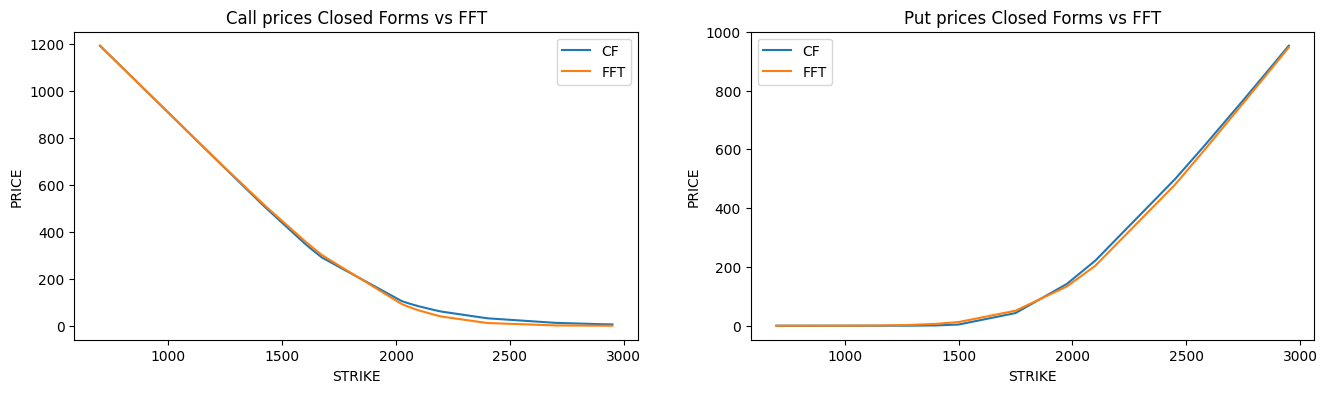

In [8]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label='CF')
ax1.plot(call_strikes, c_vg_fft, label='FFT')
ax1.set_title('Call prices Closed Forms vs FFT'); ax1.set_xlabel('STRIKE'); ax1.set_ylabel('PRICE')
# ax1.set_xlim([1400,2000]);ax1.set_ylim([0,800])

ax2.plot(put_strikes, put_th_prices['VarianceGamma'], label='CF')
ax2.plot(put_strikes, p_vg_fft, label='FFT')
ax2.set_title('Put prices Closed Forms vs FFT'); ax2.set_xlabel('STRIKE'); ax2.set_ylabel('PRICE')
ax1.legend(); ax2.legend()

## Implied volatility
The function belows implements $3$ methods to compute implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [9]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        X0 = [0.1, 0.5, 1, 3]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.5
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

Therefore, we can compute the implied volatilities taking into account the theoretical **call prices**..

In [10]:
strikes = call_th_prices['Strike'].tolist(); IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(call_th_prices)):
    IV_BS.append(implied_volatility(call_th_prices['BlackScholes'].iloc[i], S=S0, strike=strikes[i], t=T, rate=r,q=q, type_o='call', method='newton') )
    IV_M.append(implied_volatility(call_th_prices['Merton'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_K.append(implied_volatility(call_th_prices['Kou'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_VG.append(implied_volatility(call_th_prices['VarianceGamma'].values[i], S=S0, strike=strikes[i], t = T, rate=r, q=q, type_o='call', method='newton'))

imp_vol_call = pd.DataFrame(columns=['Strike', 'BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_call['Strike'] = strikes
imp_vol_call['BlackScholes'] = IV_BS
imp_vol_call['Merton'] = IV_M
imp_vol_call['Kou'] = IV_K
imp_vol_call['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for call options:\n{imp_vol_call.head(7)}')

Implied volatilities found by each model for call options:
   Strike  BlackScholes    Merton       Kou  VarianceGamma
0   700.0           0.2  0.310692  0.355674       0.168004
1   850.0           0.2  0.291918  0.325155       0.160081
2  1025.0           0.2  0.271961  0.292107       0.153206
3  1075.0           0.2  0.266608  0.282954       0.151732
4  1150.0           0.2  0.258797  0.269346       0.149983
5  1225.0           0.2  0.251128  0.255801       0.148857
6  1250.0           0.2  0.248574  0.251286       0.148637


... and **put prices**.

In [11]:
strikes = put_th_prices['Strike'].tolist(); IV_BS = []; IV_M = []; IV_K = []; IV_VG = []

for i in range(len(put_prices)):
    IV_BS.append(implied_volatility(put_th_prices['BlackScholes'].values[i], S=S0, strike=strikes[i], t=T, rate=r, q=q, type_o='put', method='newton' ) )
    IV_M.append(implied_volatility(put_th_prices['Merton'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_K.append(implied_volatility(put_th_prices['Kou'].values[i], S=S0, strike = strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_VG.append(implied_volatility(put_th_prices['VarianceGamma'].values[i], S=S0, strike=strikes[i], t = T, rate=r, q=q, type_o='put', method='newton'))

imp_vol_put = pd.DataFrame(columns=['Strike','BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
imp_vol_put['Strike'] = strikes
imp_vol_put['BlackScholes'] = IV_BS
imp_vol_put['Merton'] = IV_M
imp_vol_put['Kou'] = IV_K
imp_vol_put['VarianceGamma'] = IV_VG

print(f'Implied volatilities found by each model for put options:\n {imp_vol_put.head(7)}')

Implied volatilities found by each model for put options:
    Strike  BlackScholes    Merton       Kou  VarianceGamma
0   700.0           0.2  0.310692  0.355674       0.168004
1   825.0           0.2  0.294933  0.330065       0.161270
2   850.0           0.2  0.291918  0.325155       0.160081
3   925.0           0.2  0.283121  0.310748       0.156821
4   975.0           0.2  0.277462  0.301361       0.154906
5  1000.0           0.2  0.274692  0.296719       0.154028
6  1025.0           0.2  0.271961  0.292107       0.153206


In [12]:
print('Total absolute error IV from CALLS vs IV from PUTS: ')
print(f'> BS: ', np.linalg.norm(imp_vol_put['BlackScholes'] - imp_vol_call['BlackScholes'], 1))
print(f'> MERTON: ', np.linalg.norm(imp_vol_put['Merton'] - imp_vol_call['Merton'], 1))
print(f'> KOU: ', np.linalg.norm(imp_vol_put['Kou'] - imp_vol_call['Kou'], 1))
print(f'> VG: ', np.linalg.norm(imp_vol_put['VarianceGamma'] - imp_vol_call['VarianceGamma'], 1))

Total absolute error IV from CALLS vs IV from PUTS: 
> BS:  3.8415796341229047e-07
> MERTON:  0.4361746421819664
> KOU:  0.6133586109803628
> VG:  0.1662651719266103


##### Plot

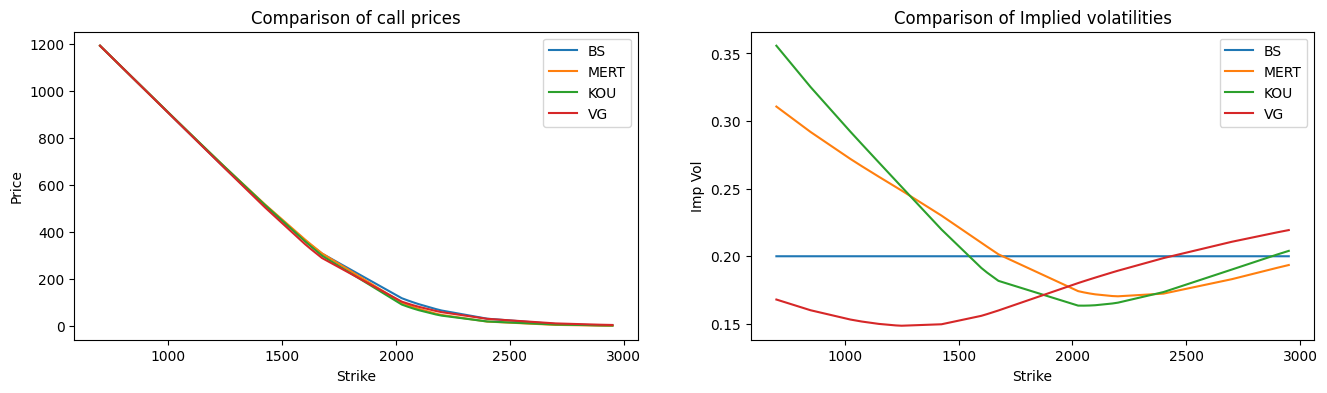

In [13]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(call_strikes, call_th_prices['BlackScholes'], label="BS"); ax1.plot(call_strikes, call_th_prices['Merton'], label="MERT")
ax1.plot(call_strikes, call_th_prices['Kou'], label="KOU"); ax1.plot(call_strikes, call_th_prices['VarianceGamma'], label="VG")
ax1.set_title("Comparison of call prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(call_strikes, imp_vol_call['BlackScholes'], label="BS"); ax2.plot(call_strikes, imp_vol_call['Merton'], label="MERT")
ax2.plot(call_strikes, imp_vol_call['Kou'], label="KOU"); ax2.plot(call_strikes, imp_vol_call['VarianceGamma'], label="VG")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

##  Calibration
Let's step now into the calibration of model parameters. We test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works both with and without bounds. When bounds are set it uses the [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region) and the [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) when they are not.
2. **minimize(method='SLSQP')**, a constrained minimization problem which uses [Sequential Quadratic Programming](https://en.wikipedia.org/wiki/Sequential_quadratic_programming).
First we initialize a starting point in the array $x_0 = [σ, λ, m, v]$, then we set

### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [14]:
x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 1e-2, -10, 0.1], [np.inf, np.inf, 10, 5] )

def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)


##### Method 1. Bounds

In [15]:
res1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],4)
lambdt = round(res1[0][1],2)
mt = round(res1[0][2],2)
vt = round(res1[0][3],5)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigt} \t {sigt*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Jump Mean = ', mt)
print('> Calibrated Jump St. dev.  = ', vt)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.0001 	 0.01%
> Calibrated Jump intensity [λ] =  0.51
> Calibrated Jump Mean =  0.09
> Calibrated Jump St. dev.  =  0.1


##### Method 1. No bounds

In [16]:
res1_2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0)

sigt2 = round(res1_2[0][0],4)
lambdt2 = round(res1_2[0][1],2)
mt2 = round(res1_2[0][2],2)
vt2 = round(res1_2[0][3],5)

print('METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)')
print(f'> Calibrated Volatlity [σ] = {sigt2} \t {sigt2*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdt2)
print('> Calibrated Jump Mean = ', mt2)
print('> Calibrated Jump St. dev.  = ', vt2)

METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)
> Calibrated Volatlity [σ] = -0.0059 	 -0.59%
> Calibrated Jump intensity [λ] =  0.33
> Calibrated Jump Mean =  0.17
> Calibrated Jump St. dev.  =  0.00451


##### Method 2. Bounds

In [17]:
x0 = [0.3, 0.8, -0.3, 0.4]      # initial guess: [σ, λ, m, v]
bounds = [(1e-6, 10), (0, 20), (-10, 10),  (0, 15)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, mean, std = x
    Mert = Merton_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, lambd=lamb, meanJ=mean, stdJ=std, exercise=exercise)
    return np.sum((Mert.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

print('> METHOD 2: MINIMIZE (SLSQP)')
res2_1 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)
print(res2_1.message)
sigt3, lambdt3, mt3, vt3 = res2_1.x

# Print the results
print(f'Calibrated Volatility [σ] = {round(sigt3, 5)}, \t  {sigt3*100}%')
print('Calibrated Jump Intensity [λ] =', round(lambdt3, 2))
print('Calibrated Jump Mean [m] =', round(mt3, 2))
print('Calibrated Jump St. dev. [v] =', round(vt3, 2))


print('\n> METHOD 2: MINIMIZE (trust-constr)')
res2_2 = scpo.minimize(obj_function, x0, args=additional_args,  method='trust-constr', bounds=bounds, tol=1e-20)
print(res2_1.message)
sigt4, lambdt4, mt4, vt4 = res2_2.x

# Print the results
print(f'Calibrated Volatility [σ] = {round(sigt4, 5)}, \t  {sigt4*100}%')
print('Calibrated Jump Intensity [λ] =', round(lambdt4, 2))
print('Calibrated Jump Mean [m] =', round(mt4, 2))
print('Calibrated Jump St. dev. [v] =', round(vt4, 2))

> METHOD 2: MINIMIZE (SLSQP)
Optimization terminated successfully
Calibrated Volatility [σ] = 3.02477, 	  302.4767067192379%
Calibrated Jump Intensity [λ] = 6.19
Calibrated Jump Mean [m] = -3.02
Calibrated Jump St. dev. [v] = 4.5

> METHOD 2: MINIMIZE (trust-constr)


C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\BSpricer.py:71: RuntimeWarning: overflow encountered in exp
  return S0 * np.exp(-q*ttm) * ss.norm.cdf(d1) - K * np.exp(-r * ttm) * ss.norm.cdf(d2)
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\BSpricer.py:71: RuntimeWarning: invalid value encountered in scalar multiply
  return S0 * np.exp(-q*ttm) * ss.norm.cdf(d1) - K * np.exp(-r * ttm) * ss.norm.cdf(d2)
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: overflow encountered in power
  V += (np.exp(-mean * self.lambd * self.ttm) * np.power(mean * self.lambd * self.ttm, k)) / k_fact *\
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: invalid value encountered in scalar multiply
  V += (np.exp(-mean * self.lambd * self.ttm)

Optimization terminated successfully
Calibrated Volatility [σ] = 0.63698, 	  63.698406249837134%
Calibrated Jump Intensity [λ] = 0.88
Calibrated Jump Mean [m] = -0.34
Calibrated Jump St. dev. [v] = 0.57


In [20]:
mert_params = [sigt, lambdt, mt, vt]
print(mert_params)

[0.0001, 0.51, 0.09, 0.1]


### Kou Jump Diffusion

In [21]:
x0 = [0.1, 0.5, 0.4, 5, 5] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [0, 0, 0, 0, 0], [4, 10, 0.9,  10, 10] )

def f_Kou(x, sigma, lambd, p, eta1, eta2):
    KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return KouJD.closed_formula_call(x)

##### Method 1. TRF (Bounds)

In [22]:
res1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
pt = round(res1[0][2],2)
eta1_t = round(res1[0][3],1)
eta2_t = round(res1[0][4],1)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {sigt} \t {sigt*100}%')
print('> Calibrated Jump intensity [λ] = ', lambdt)
print(f'> Calibrated Upward Jump probability [p] = {pt}, [q] = {round(1-pt,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', eta1_t)
print('> Calibrated Rate of Exp. 2  [η_2] = ', eta2_t)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.09665 	 9.665%
> Calibrated Jump intensity [λ] =  0.11
> Calibrated Upward Jump probability [p] = 0.9, [q] = 0.1
> Calibrated Rate of Exp. 1  [η_1] =  8.1
> Calibrated Rate of Exp. 2  [η_2] =  10.0


##### Method 2. Bounds

In [23]:
x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_2]
bounds = [(0, 4), (0, 10), (0, 1),  (1e-6, 10), (1e-6,10)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, p, eta1, eta2 = x
    KouJD = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    return np.sum((KouJD.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)
print('METHOD 2: MINIMIZE (SLSQP)'); print(f'message: {res2.message}\nsuccess:{res2.success}')

sigt2, lambdt2, pt2, eta1_t2, eta2_t2 = res2.x

print(f'> Calibrated Volatlity [σ] = {round(sigt2,4)} \t {round(sigt2*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(lambdt2,2))
print(f'> Calibrated Upward Jump probability [p] = {round(pt2,2)}, [q] = {round(1-pt2,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(eta1_t2,2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(eta2_t2,2))

res3 = scpo.minimize(obj_function, x0, args=additional_args,  method='trust-constr', bounds=bounds, tol=1e-20)
print('METHOD 2: MINIMIZE (trust-constr)'); print(f'message: {res3.message}\nsuccess:{res3.success}')

sigt3, lambdt3, pt3, eta1_t3, eta2_t3 = res3.x

print(f'> Calibrated Volatlity [σ] = {round(sigt3,4)} \t {round(sigt3*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(lambdt3,2))
print(f'> Calibrated Upward Jump probability [p] = {round(pt3,2)}, [q] = {round(1-pt3,2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(eta1_t3,2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(eta2_t3,2))

METHOD 2: MINIMIZE (SLSQP)
message: Optimization terminated successfully
success:True
> Calibrated Volatlity [σ] = 0.3624 	 36.24%
> Calibrated Jump intensity [λ] =  1.38
> Calibrated Upward Jump probability [p] = 0.5, [q] = 0.5
> Calibrated Rate of Exp. 1  [η_1] =  7.21
> Calibrated Rate of Exp. 2  [η_2] =  3.6


c:\users\ornel\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


METHOD 2: MINIMIZE (trust-constr)
message: `xtol` termination condition is satisfied.
success:True
> Calibrated Volatlity [σ] = 0.7729 	 77.29%
> Calibrated Jump intensity [λ] =  0.81
> Calibrated Upward Jump probability [p] = 0.58, [q] = 0.42
> Calibrated Rate of Exp. 1  [η_1] =  7.91
> Calibrated Rate of Exp. 2  [η_2] =  3.99


The following code snippet samples a subset of observations in order to speed up the estimation of parameters in Kou's model.

In [24]:
# Sample of rows of the call dataframe
call_resized = calls.sample(n=6).sort_index()
c_strikes_resized = call_resized['STRIKE']
c_prices_resized = call_resized['C_Midpoint']

x0 = [0.1, 0.5, 0.5, 8, 4] # initial guess: [σ, λ, p, η_1, η_2]

bounds1 = ( [0, 0, 0, 1e-9, 1e-9], [4, 10, 1,  10, 10] )
res1 = scpo.curve_fit(f_Kou, c_strikes_resized, c_prices_resized, p0=x0, bounds=bounds1)
print(res1[0])

bounds2 = [(0, 4), (0, 10), (0, 1),  (1e-9, 20), (1e-9,20)]
additional_args = (c_strikes_resized, c_prices_resized)
res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)
print(res2)

[0.08512502 0.2409362  1.         9.99999998 9.95025   ]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 575222.9240375672
       x: [ 6.432e-01  3.450e+00  4.683e-01  1.054e+01  4.490e+00]
     nit: 13
     jac: [-7.812e-01 -2.344e-02  8.594e-02  7.812e-03  1.562e-02]
    nfev: 131
    njev: 13


In [26]:
kou_params = [sigt, lambdt, pt, eta1_t, eta2_t]
print(kou_params)

[0.09665, 0.11, 0.9, 8.1, 10.0]


### Variance Gamma


In [27]:
x0 = [0.2, -0.05, 0.1]   # initial guess: [σ, θ, v]
bounds = ( [1e-2, -10, 0], [5, 10, 20] )

##### Method 1. Bounds (TRF)

In [28]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

res1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
thetat = round(res1[0][1],2)
nut = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)');
print(f'> Calibrated Volatlity [σ] = {sigt}, \t {sigt*100}%')
print('> Calibrated mean rate gamma process [θ] = ', thetat)
print('> Calibrated variance rate gamma process [v]= ', nut)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.01425, 	 1.425%
> Calibrated mean rate gamma process [θ] =  -0.22
> Calibrated variance rate gamma process [v]=  0.23


##### Method 2. Bounds

In [29]:
bounds2 = [(1e-9, 5), (-4, np.inf), (0, np.inf)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, theta, nu = x
    VGx = VG_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, theta=theta, nu=nu, exercise=exercise)
    return np.sum((VGx.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

# METHOD SEQUENTIAL LEAST SQUARES
res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds2, tol=1e-20)
print('METHOD 2: MINIMIZE (SLSQP)'); print(f'message: {res2.message}\nsuccess: {res2.success}')
sigt2, thetat2, nut2 = res2.x

# Print the results
print(f'> Calibrated Volatlity [σ] = {round(sigt2,4)} \t {round(sigt2*100, 2)}%')
print('> Calibrated mean rate gamma process [θ] = ', round(thetat2, 2))
print('> Calibrated variance rate gamma process [v]= ', round(nut2,2))

# METHOD TRUST REGION CONSTRAINED
res3 = scpo.minimize(obj_function, x0, args=additional_args,  method='trust-constr', bounds=bounds2, tol=1e-20)
print('METHOD 2: MINIMIZE (trust-constr)'); print(f'message: {res3.message}\nsuccess: {res3.success}')
sigt3, thetat3, nut3 = res3.x

# Print the results
print(f'> Calibrated Volatlity [σ] = {round(sigt3,4)} \t {round(sigt3*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', round(thetat3,2))
print('> Calibrated variance rate gamma process [v]= ', round(nut3,2))

c:\users\ornel\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:67: RuntimeWarning: invalid value encountered in sqrt
  call = self.S0 * Psy(d * np.sqrt((1 - c1) / self.nu), (alpha + s) * np.sqrt(self.nu / (1 - c1)),
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:52: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = quad(f, 0, np.inf)
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:69: RuntimeWarning: invalid value encountered in sqrt
  Psy(d

METHOD 2: MINIMIZE (SLSQP)
message: Optimization terminated successfully
success: True
> Calibrated Volatlity [σ] = 5.0 	 500.0%
> Calibrated mean rate gamma process [θ] =  -4.0
> Calibrated variance rate gamma process [v]=  196.63


c:\users\ornel\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


METHOD 2: MINIMIZE (trust-constr)
message: `xtol` termination condition is satisfied.
success: True
> Calibrated Volatlity [σ] = 0.762 	 76.2%
> Calibrated mean rate gamma process [θ] =  0.02
> Calibrated variance rate gamma process [v]=  0.4


##### Method 1 using FFT prices

In [30]:
def f_VG_fft(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    return VGamma.FFT_call(strikes)

res4 = scpo.curve_fit(f_VG_fft, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt4 = round(res1[0][0],5)
thetat4 = round(res1[0][1],2)
nut4 = round(res1[0][2],2)

print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(sigt4,4)} \t {round(sigt4*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', thetat4)
print('> Calibrated variance rate gamma process [v]= ', nut4)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.0142 	 1.42%
> Calibrated mean rate gamma process [θ] =  -0.22
> Calibrated variance rate gamma process [v]=  0.23


In [31]:
vg_params = [sigt, thetat, nut]
print(vg_params)

[0.01425, -0.22, 0.23]
